In [1]:
import os

import equinox as eqx
import jax
import jax.numpy as jnp

os.environ["LOGURU_LEVEL"] = "INFO"

In [92]:
import demes


def build_grid_demes(m: int, n: int):
    b = demes.Builder(time_units="generations")
    tau = 1e5
    # Ancestral population
    b.add_deme(
        "ancestral",
        epochs=[dict(end_time=tau, start_size=1e4)],
    )

    # Grid demes
    for i in range(m):
        for j in range(n):
            name = f"deme_{i}_{j}"
            b.add_deme(
                name,
                ancestors=["ancestral"],
                epochs=[
                    dict(
                        end_time=0,
                        start_size=1e4,
                    )
                ],
            )
    for i in range(m):
        for j in range(n):
            neighbors = [
                (i + x, j + y)
                for x in [-1, 0, 1]
                for y in [-1, 0, 1]
                if all(
                    [abs(x) + abs(y) == 1, i + x >= 0, i + x < m, j + y >= 0, j + y < n]
                )
            ]
            name = f"deme_{i}_{j}"
            for u, v in neighbors:
                neigh = f"deme_{u}_{v}"
                b.add_migration(
                    source=name, dest=neigh, start_time=tau, end_time=0, rate=0.01 * j
                )

    graph = b.resolve()
    return graph

In [93]:
M = 4
N = 3
g = build_grid_demes(M, N)

In [94]:
len(g.demes)

13

In [95]:
# simulate data
import msprime as msp

demo = msp.Demography.from_demes(g)
samples = {f"deme_{i}_{j}": 5 for i in range(M) for j in range(N)}
ts = msp.sim_ancestry(
    demography=demo, samples=samples, sequence_length=1e7, recombination_rate=1e-8
)

In [96]:
ts

In [64]:
import demesinfer.iicr

ii = demesinfer.iicr.IICRCurve(g, 2)

In [65]:
# map migration to variable
migr_paths = {}
for i, m in enumerate(g.migrations):
    src = tuple(map(int, m.source.split("_")[1:]))
    dst = tuple(map(int, m.dest.split("_")[1:]))
    migr_paths[src, dst] = frozenset([("migrations", i, "rate")])

size_paths = {}
for i, d in enumerate(g.demes):
    did = tuple(map(int, d.name.split("_")[1:]))
    size_paths[did] = frozenset(
        [("demes", i, "epochs", 0, f"{x}_size") for x in ["start", "end"]]
    )


class Params(eqx.Module):
    m: jax.Array
    q: jax.Array

    def xform(self):
        return Params(m=jnp.log(self.m), q=jnp.log(self.q))

    def unxform(self):
        return Params(m=jnp.exp(self.m), q=jnp.exp(self.q))

    def to_di_params(self):
        out = {}
        for i in range(M):
            for j in range(N):
                deme0 = (i, j)
                s = size_paths[deme0]
                out[s] = self.q[deme0]
                for u in range(M):
                    for v in range(N):
                        deme1 = (u, v)
                        key = (deme0, deme1)
                        if key in migr_paths:
                            m = migr_paths[key]
                            out[m] = self.m[deme0][deme1]
        return out

In [66]:
q = jnp.ones([M, N]) * 1e4
m = jnp.ones([M, N, M, N]) / 1000
p0 = Params(m=m, q=q)

In [67]:
import jax


@jax.jit
def loglik(params: Params, times, num_samples):
    p = params.unxform().to_di_params()
    crv = ii.curve(num_samples, p)
    ds = jax.vmap(crv)(times)
    return jnp.mean(jnp.log(ds["c"]) + ds["log_s"])


def neg_loglik(params, times, num_samples):
    return -loglik(params, times, num_samples)


@jax.jit
@jax.value_and_grad
def loss(params: Params, times, num_samples):
    return -jax.vmap(loglik, (None, 0, 0))(params, times, num_samples).mean()

In [68]:
import numpy as np

nodes_for_pop = {}
for pop in ts.populations():
    nodes_for_pop[pop.metadata["name"]] = np.array(
        [i.nodes for i in ts.individuals() if ts.individual_populations[i.id] == pop.id]
    ).reshape(-1)

nodes_for_pop.pop("ancestral")


def get_tmrcas(pop0, pop1):
    tree = ts.first()
    tmrcas = []
    for i in range(0, ts.num_trees, 100):
        tree.seek_index(i)
        for x in nodes_for_pop[pop0]:
            for y in nodes_for_pop[pop1]:
                if x != y:
                    tmrcas.append(tree.get_tmrca(x, y))
    return np.array(tmrcas)

In [69]:
import itertools

deme_names = [d.name for d in g.demes]

In [89]:
import itertools as it
import random

import optax

from demesinfer.util import tree_stack

random.seed(42)

opts = dict(m=optax.adam(1e-2), q=optax.adam(1e-2))

opt_state = {}
p = p0.xform()
opt_state["m"] = opts["m"].init(Params(m=p.m, q=None))
opt_state["q"] = opts["q"].init(Params(m=None, q=p.q))

nodes = list(nodes_for_pop)

for i in range(100):
    times = []
    ns = []
    for _ in range(5):
        pop0, pop1 = random.sample(nodes, 2)
        times.append(get_tmrcas(pop0, pop1))
        ns.append({k: 0 for k in nodes_for_pop})
        ns[-1][pop0] += 1
        ns[-1][pop1] += 1
    times = jnp.array(times)
    ns = tree_stack(ns)
    with jax.debug_nans(True), jax.disable_jit(True):
        f, grads = loss(p, times, ns)
    grads = eqx.filter(grads, Params(m=True, q=False))
    updates_m, opt_state["m"] = opts["m"].update(grads, opt_state["m"])
    p = eqx.apply_updates(p, updates_m)
    with jax.debug_nans(True):
        f, grads = loss(p, times, ns)
    grads = eqx.filter(grads, Params(m=False, q=True))
    updates_q, opt_state["q"] = opts["q"].update(grads, opt_state["q"])
    p = eqx.apply_updates(p, updates_q)
    print(f)

13.769858
13.77533
13.781908
13.774623
13.772756
13.776671
13.776128
13.763278
13.782241
13.778241
13.764671
13.7646055
13.769791
13.773539
13.767699
13.77269
13.774852
13.773097
13.782852


KeyboardInterrupt: 

(array([   71.,    98.,   224.,   631.,  1933.,  3916.,  8252., 15907.,
        36347., 46921.]),
 array([1.85221943, 2.20397934, 2.55573924, 2.90749915, 3.25925906,
        3.61101897, 3.96277888, 4.31453879, 4.66629869, 5.0180586 ,
        5.36981851]),
 <BarContainer object of 10 artists>)

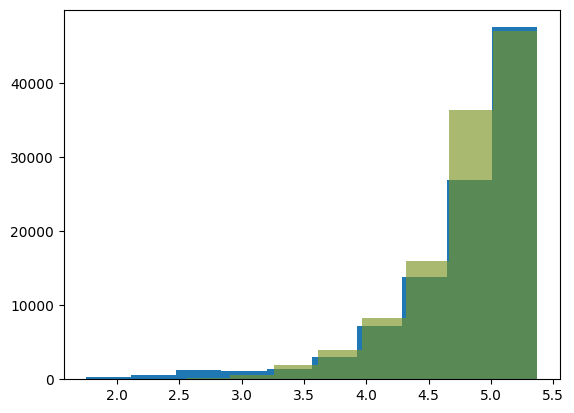

In [85]:
plt.hist(np.log10(get_tmrcas("deme_0_0", "deme_0_0")))
plt.hist(np.log10(get_tmrcas("deme_0_0", "deme_0_1")), alpha=0.4)
plt.hist(np.log10(get_tmrcas("deme_0_0", "deme_0_1")), alpha=0.4)

In [90]:
np.mean(get_tmrcas("deme_0_0", "deme_0_0"))

np.float64(81300.63225166396)

In [91]:
np.mean(get_tmrcas("deme_0_0", "deme_0_1"))

np.float64(82926.22891749092)